## 4.4. 模型选择、欠拟合和过拟合

### 4.4.1. 训练误差和泛化误差

为了进一步讨论这一现象，我们需要了解训练误差和泛化误差。 训练误差（training error）是指， 模型在训练数据集上计算得到的误差。 泛化误差（generalization error）是指， 模型应用在同样从原始样本的分布中抽取的<font color=red>无限多</font>数据样本时，模型误差的期望。

影响模型泛化的因素：

1. 可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合。

2. 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。

3. 训练样本的数量。即使你的模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

### 4.4.2. 模型选择

例如，训练多层感知机模型时，我们可能希望比较具有 不同数量的隐藏层、不同数量的隐藏单元以及不同的激活函数组合的模型。 为了确定候选模型中的最佳模型，我们通常会使用验证集。



#### 4.4.2.1. 验证集

原则上，在我们确定所有的超参数之前，我们不希望用到测试集。 如果我们在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险，那就麻烦大了。 如果我们过拟合了训练数据，还可以在测试数据上的评估来判断过拟合。 但是如果我们过拟合了测试数据，我们又该怎么知道呢？

因此，我们决不能依靠测试数据进行模型选择。 然而，我们也不能仅仅依靠训练数据来选择模型，因为我们无法估计训练数据的泛化误差。

在实际应用中，情况变得更加复杂。 虽然理想情况下我们只会使用测试数据一次， 以评估最好的模型或比较一些模型效果，但现实是测试数据很少在使用一次后被丢弃。 我们很少能有充足的数据来对每一轮实验采用全新测试集。

解决此问题的常见做法是将我们的数据分成三份， 除了训练和测试数据集之外，还增加一个验证数据集（validation dataset）， 也叫验证集（validation set）。 但现实是验证数据和测试数据之间的边界模糊得令人担忧。 除非另有明确说明，否则在这本书的实验中， 我们实际上是在使用应该被正确地称为训练数据和验证数据的数据集， 并没有真正的测试数据集。 因此，书中每次实验报告的准确度都是验证集准确度，而不是测试集准确度。

### 4.4.3. 欠拟合还是过拟合

### 4.4.4. 多项式回归

In [3]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

/home/mkid/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811748419/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


#### 4.4.4.1. 生成数据集

[使用以下三阶多项式来生成训练和测试数据的标签](https://zh.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html#id11)

In [4]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))    # x^0, x^1, ..., x^(n-1)
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
# numpy.random.normal(loc=0.0, scale=1.0, size=None)
# loc: mean, scale: std
labels += np.random.normal(scale=0.1, size=labels.shape)

存储在poly_features中的单项式由gamma函数重新缩放

从生成的数据集中查看一下前2个样本， 第一个值是与偏置相对应的常量特征(b = x^0)。



In [7]:
# NumPy ndarray转换为tensor
# print(f'true_w = {true_w}, features = {features}, poly_features = {poly_features}, labels = {labels}')
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

/home/mkid/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


(tensor([[0.0036],
         [0.7254]]),
 tensor([[1.0000e+00, 3.6190e-03, 6.5486e-06, 7.8998e-09, 7.1474e-12, 5.1733e-15,
          3.1204e-18, 1.6132e-21, 7.2979e-25, 2.9346e-28, 1.0620e-31, 3.4940e-35,
          1.0537e-38, 2.9329e-42, 1.4013e-45, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.0000e+00, 7.2538e-01, 2.6308e-01, 6.3612e-02, 1.1536e-02, 1.6735e-03,
          2.0232e-04, 2.0966e-05, 1.9010e-06, 1.5322e-07, 1.1114e-08, 7.3288e-10,
          4.4301e-11, 2.4719e-12, 1.2808e-13, 6.1936e-15, 2.8079e-16, 1.1981e-17,
          4.8282e-19, 1.8433e-20]]),
 tensor([4.9851, 5.2611]))

#### 4.4.4.2. 对模型进行训练和测试

In [8]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [9]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

#### 4.4.4.3. 三阶多项式函数拟合(正常)

weight: [[ 4.984089   1.1982358 -3.3853092  5.607055 ]]


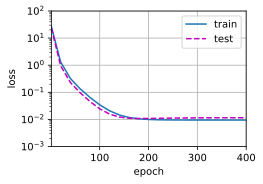

In [10]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

#### 4.4.4.4. 线性函数拟合(欠拟合)


weight: [[3.3708467 4.1195636]]


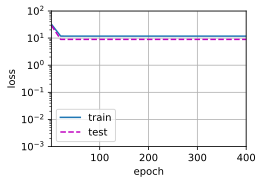

In [11]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

#### 4.4.4.5. 高阶多项式函数拟合(过拟合)

weight: [[ 5.0021253   1.2975065  -3.429192    5.1177597   0.044604    1.2421583
   0.24843596  0.21724156 -0.14707123 -0.17210577  0.09577827 -0.01464224
   0.10410231 -0.06647862  0.21123916  0.17953701 -0.14723945 -0.18966709
  -0.17914908 -0.17832218]]


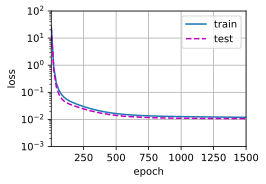

In [13]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)